In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

In [4]:
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [5]:
cls_conf = ffhq256_autoenc_cls()
cls_model = ClsModel(cls_conf)
state = torch.load(f'checkpoints/{cls_conf.name}/last.ckpt',
                    map_location='cpu')
print('latent step:', state['global_step'])
cls_model.load_state_dict(state['state_dict'], strict=False)
cls_model.to(device);

Global seed set to 0


loading pretrain ... 130M
step: 1563562
loading latent stats ...
latent step: 9375


In [6]:
img_from_dir = 'imgs_align'
for i,file in enumerate(os.listdir(img_from_dir)):
    print(f'{i:2}: {file}')

 0: azuki_default.png
 1: ceo_default.png
 2: check1.png
 3: check2.png
 4: danda_default.png
 5: detective.png
 6: detective_02.png
 7: idPhoto.png
 8: mio_happy.png
 9: mio_shock.png
10: mio_silence.png
11: mio_u.png
12: nanko_default.png
13: ookawa_angry.png
14: ookawa_angry2.png
15: ookawa_default.png
16: ookawa_high.png
17: ookawa_regret.png
18: ookawa_smile.png
19: ookawa_surprised.png
20: pharmacist.png
21: saki.png
22: saki_glasses.png
23: sandy.png
24: takebe_default.png
25: test01.png
26: test01_02.png
27: test01_03.png
28: test01_04.png
29: test02.png
30: woman_default.png
31: yotaka_angry.png
32: yotaka_angry2.png
33: yotaka_bald.png
34: yotaka_bushy.png
35: yotaka_default.png
36: yotaka_gj.png
37: yotaka_smile.png
38: yotaka_smile2.png


In [7]:
img_to_dir = 'imgs_align'
for i,file in enumerate(os.listdir(img_to_dir)):
    print(f'{i:2}: {file}')

 0: azuki_default.png
 1: ceo_default.png
 2: check1.png
 3: check2.png
 4: danda_default.png
 5: detective.png
 6: detective_02.png
 7: idPhoto.png
 8: mio_happy.png
 9: mio_shock.png
10: mio_silence.png
11: mio_u.png
12: nanko_default.png
13: ookawa_angry.png
14: ookawa_angry2.png
15: ookawa_default.png
16: ookawa_high.png
17: ookawa_regret.png
18: ookawa_smile.png
19: ookawa_surprised.png
20: pharmacist.png
21: saki.png
22: saki_glasses.png
23: sandy.png
24: takebe_default.png
25: test01.png
26: test01_02.png
27: test01_03.png
28: test01_04.png
29: test02.png
30: woman_default.png
31: yotaka_angry.png
32: yotaka_angry2.png
33: yotaka_bald.png
34: yotaka_bushy.png
35: yotaka_default.png
36: yotaka_gj.png
37: yotaka_smile.png
38: yotaka_smile2.png


In [25]:
data = ImageDataset(img_from_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
ind_batch_from = [35,37]
num_from = len(ind_batch_from)
batch_from = []
names_batch_from = []
for i in range(len(ind_batch_from)):
    batch_from.append(data[ind_batch_from[i]]['img'])
    names_batch_from.append(os.path.splitext(str(data.paths[ind_batch_from[i]]))[0])
batch_from = torch.stack(batch_from)

data2 = ImageDataset(img_to_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
ind_batch_to = [24,30]
num_to = len(ind_batch_to)
batch_to = []
names_batch_to = []
for i in range(num_to):
    batch_to.append(data2[ind_batch_to[i]]['img'])
    names_batch_to.append(os.path.splitext(str(data2.paths[ind_batch_to[i]]))[0])
batch_to = torch.stack(batch_to)

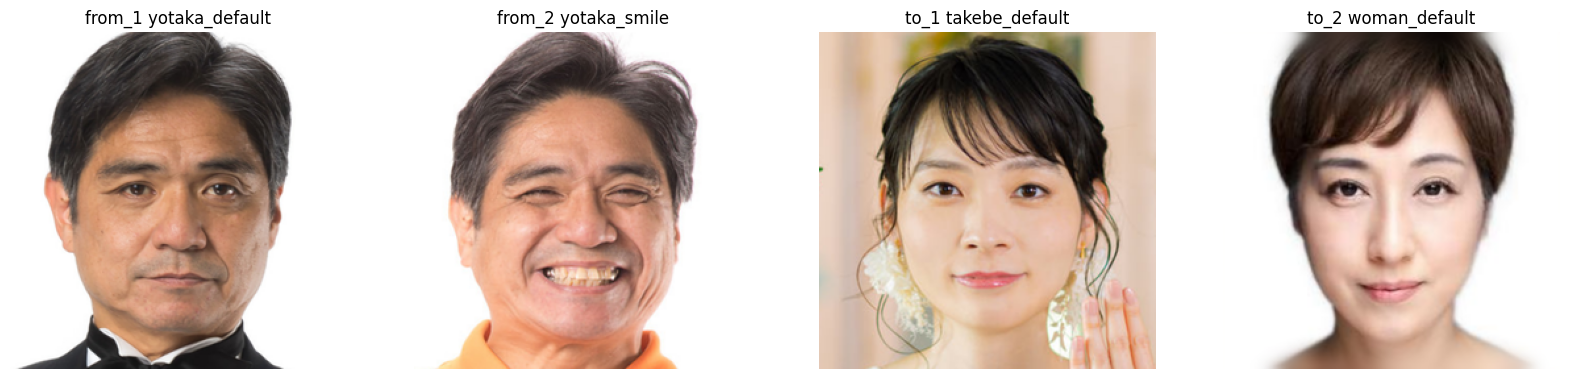

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2+num_to, figsize=(5*(num_from+num_to), 5))
for i in range(num_from):
    ax[i].imshow(batch_from[i].permute([1, 2, 0]) / 2 + 0.5)
    ax[i].set_title(f"from_{i+1} {names_batch_from[i]}")

for i in range(num_to):
    ax[i+num_from].imshow(batch_to[i].permute([1, 2, 0]) / 2 + 0.5)
    ax[i+num_from].set_title(f"to_{i+1} {names_batch_to[i]}")

for i in range(2+num_to):
    ax[i].axis('off')
plt.show()

In [27]:
# 転写元
cond_from = model.encode(batch_from.to(device))
xT_from = model.encode_stochastic(batch_from.to(device), cond_from, T=250)
cond_change = cls_model.normalize(cond_from[1][None]) - cls_model.normalize(cond_from[0][None])

# 転写先
cond_to = torch.tensor([], device=device)
cond_to_norm = torch.tensor([], device=device)
xT_to = torch.tensor([], device=device)
for i in range(num_to):
    cond_to = torch.cat([cond_to, model.encode(batch_to[i][None].to(device))], dim=0)
    cond_to_norm = torch.cat([cond_to_norm, cls_model.normalize(cond_to[i])], dim=0)
    xT_to = torch.cat([xT_to, model.encode_stochastic(batch_to[i][None].to(device), cond_to[i][None], T=250)], dim=0)

In [28]:
def cos(a, b):
    a = a.view(-1)
    b = b.view(-1)
    a = F.normalize(a, dim=0)
    b = F.normalize(b, dim=0)
    return (a * b).sum()

alpha = torch.tensor(np.linspace(0, 1, 11, dtype=np.float32)).to(device)

intp_from = cond_from[0][None] * (1 - alpha[:, None]) + cond_from[1][None] * alpha[:, None]
theta_from = torch.arccos(cos(xT_from[0], xT_from[1]))
x_shape = xT_from[0].shape
intp_x_from = (torch.sin((1 - alpha[:, None]) * theta_from) * xT_from[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta_from) * xT_from[1].flatten(0, 2)[None]) / torch.sin(theta_from)
intp_x_from = intp_x_from.view(-1, *x_shape)

In [29]:
xTs = torch.tensor([], device=device)
conds = torch.tensor([], device=device)
for i in range(num_to):
    xTs_tmp = torch.tensor([], device=device)
    conds_tmp = torch.tensor([], device=device)
    xT_change = xT_to[i] - intp_x_from[0]
    xT_to_s = torch.linalg.norm(xT_to[i])
    for j,alp in enumerate(alpha):
        xT2 = intp_x_from[j] + xT_change
        xT2_s = torch.linalg.norm(xT2)
        xT2 = xT2 / xT2_s * xT_to_s
        xTs_tmp = torch.cat([xTs_tmp, xT2[None]], dim=0)
        xT_change = xTs_tmp[j] - intp_x_from[j]
        xT_to_s = torch.linalg.norm(xTs_tmp[j])
        cond2 = cond_to_norm[i] + alp * cond_change
        cond2 = cls_model.denormalize(cond2)
        conds_tmp = torch.cat([conds_tmp, cond2], dim=0)
    xTs = torch.cat([xTs, xTs_tmp[None]], dim=0)
    conds = torch.cat([conds, conds_tmp[None]], dim=0)

In [30]:
preds = torch.tensor([], device=device)
for i in range(num_to):
    preds_tmp = torch.tensor([], device=device)
    for j in range(len(alpha)):
        pred = model.render(xTs[i,j][None], conds[i,j][None], T=20)
        preds_tmp = torch.cat([preds_tmp, pred], dim=0)
    preds = torch.cat([preds, preds_tmp[None]], dim=0)

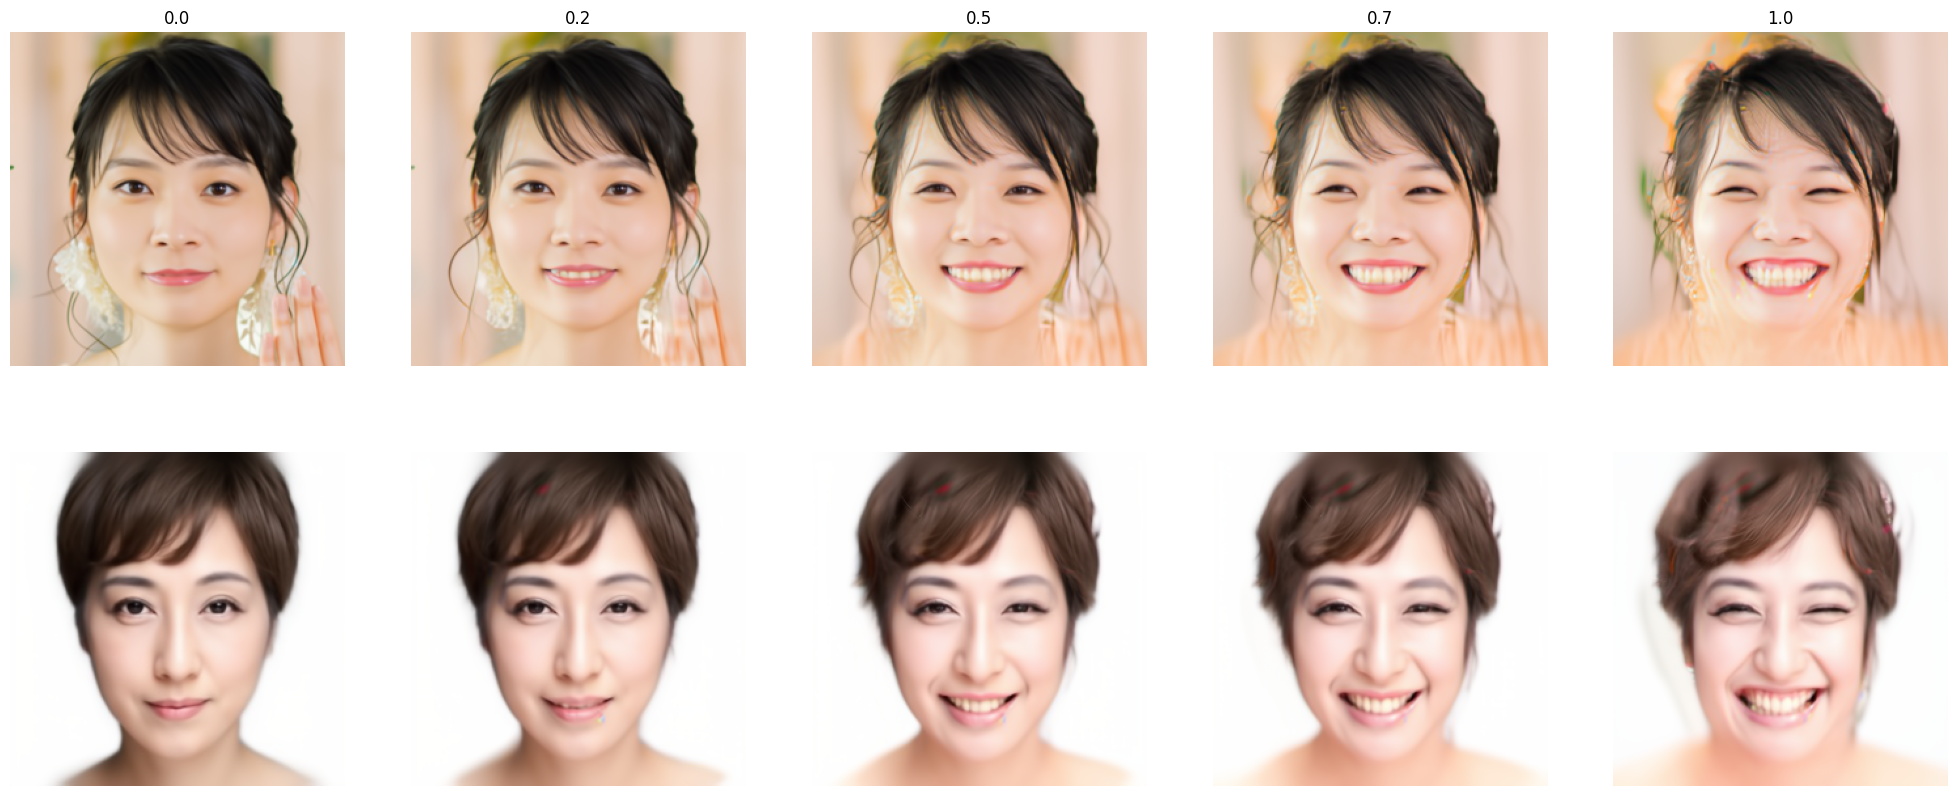

In [31]:
import matplotlib.pyplot as plt

num_show = 5
fig,ax = plt.subplots(num_to, num_show, figsize=(5*num_show, 5*num_to))
for i,pred in enumerate(preds):
    for j,k in enumerate(np.linspace(0,len(pred)-1,num_show,dtype=np.uint8)):
        if len(preds) < 2:
            ax[j].imshow(pred[k].permute(1,2,0).cpu())
            ax[j].set_title(np.array(alpha[k].cpu()))
            ax[j].axis('off')
        else:
            ax[i,j].imshow(pred[k].permute(1,2,0).cpu())
            if i == 0:
                ax[i,j].set_title(np.array(alpha[k].cpu()))
            ax[i,j].axis('off')

In [32]:
from PIL import Image

preds_pil = []
for pred in preds:
    pred_pil = []
    for p in pred:
        p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
        pred_pil.append(Image.fromarray(p_np))
    preds_pil.append(pred_pil)

## gifの保存

### 名前自動（まとめて）

In [63]:
dst_dir = "imgs_test/imgs_transfer_xT_new/"
for i,pred_pil in enumerate(preds_pil):
    frs_dir = f"{dst_dir}{names_batch_from[0]}2{names_batch_from[1]}-trans-{names_batch_to[i]}/"
    if not os.path.exists(frs_dir): os.makedirs(frs_dir)
    file_name = f"amp{np.array(alpha.detach().cpu())[0]:.2f}_{np.array(alpha.detach().cpu())[-1]:.2f}_{len(alpha)}.gif"
    dst_path = frs_dir + file_name

    pred_pil[0].save(
        dst_path,
        format="gif",
        save_all=True,
        append_images=pred_pil,
        duration=3000//(len(alpha)),
        loop=0,
    )

### 名前手動（ひとつずつ）

In [254]:
for i, name in enumerate(names_batch_to):
    print(f'{i:2}: {name}')

 0: azuki_default
 1: danda_default
 2: nanko_default
 3: ookawa_default
 4: takebe_default
 5: woman_default


In [82]:
index = 0
dst_dir = "imgs_test/imgs_transfer/"
file_name = "yotaka2smile-trans-women.gif"
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
dst_path = dst_dir + file_name

preds_pil[index][0].save(
    dst_path,
    format="gif",
    save_all=True,
    append_images=preds_pil[index],
    duration=120//(len(alpha)-1),
    loop=0,
)

## 静止画像（フレーム）の保存

### 名前自動（まとめて）

In [64]:
from torchvision.utils import save_image

dst_dir = "imgs_test/imgs_transfer_xT_new/"
# select_ind = {0,12,24,36,47,59}
select_ind = {0,2,4,6,8,10}
for i,pred in enumerate(preds):
    frs_dir = f"{dst_dir}{names_batch_from[0]}2{names_batch_from[1]}-trans-{names_batch_to[i]}/"
    if not os.path.exists(frs_dir): os.makedirs(frs_dir)
    for j,p in enumerate(pred):
        if j in select_ind:
            file_name = f"{frs_dir}amp{np.array(alpha.detach().cpu())[j]:.2f}.png"
            save_image(p, file_name, format='PNG')

### 名前手動（ひとつずつ）

In [251]:
print('index: name')
for i, name in enumerate(names_batch_to):
    print(f'{i:5}: {name}')

index: name
    0: azuki_default
    1: danda_default
    2: nanko_default
    3: ookawa_default
    4: takebe_default
    5: woman_default


In [242]:
print('index: amplitude')
for i,a in enumerate(np.array(alpha.detach().cpu())):
    print(f'{i:5}: {a}')

index: amplitude
    0: 0.0
    1: 0.4285714328289032
    2: 0.8571428656578064
    3: 1.2857142686843872
    4: 1.7142857313156128
    5: 2.142857074737549
    6: 2.5714285373687744
    7: 3.0
    8: 3.4285714626312256
    9: 3.857142925262451
   10: 4.285714149475098
   11: 4.714285850524902
   12: 5.142857074737549
   13: 5.5714287757873535
   14: 6.0


In [ ]:
index_name = 0
index_amp = 0
dst_dir = "imgs_test/imgs_transfer/"
file_name = "yotaka2smile-trans-women.png"
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
dst_path = dst_dir + file_name
save_image(preds[index_name][index_amp], dst_path)